<a href="https://colab.research.google.com/github/shxnyoung/MLDL-woundimage/blob/main/U_net_testmodel_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras 
from keras.models import Model, load_model
from keras.layers import Input, ReLU, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import cv2
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from PIL import Image

In [ ]:
model_input = Input((128,128,3))

In [ ]:
x_train=np.load('/content/drive/My Drive/MLDL_models/ClassificationTEST/X.npy')/255.
y_train=np.load('/content/drive/My Drive/MLDL_models/ClassificationTEST/Y.npy')

In [ ]:
#granulation, slough, necrosis
def datacutter(data, l0, l1, l2):
  train0 = data[:l0,]
  train1 = data[l0:l0+l1,]
  train2 = data[l1:l1+l2,]
  return train0, train1, train2

In [ ]:
l0=730; l1=510; l2=850
x_train0, x_train1, x_train2 = datacutter(x_train, l0, l1, l2)
y_train0, y_train1, y_train2 = datacutter(y_train, l0, l1, l2)
print(x_train0.shape, x_train1.shape, x_train2.shape)
print(y_train0.shape, y_train1.shape, y_train2.shape)

(730, 128, 128, 3) (510, 128, 128, 3) (850, 128, 128, 3)
(730, 128, 128, 1) (510, 128, 128, 1) (850, 128, 128, 1)


In [ ]:
#granulation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.1, random_state=1004)

In [ ]:
x_test1=np.load('/content/drive/My Drive/MLDL_models/TESTdataset/x_test1.npy')/255.
x_test0=np.load('/content/drive/My Drive/MLDL_models/TESTdataset/x_test0.npy')/255.
x_test2=np.load('/content/drive/My Drive/MLDL_models/TESTdataset/x_test2.npy')/255.
y_test1=np.load('/content/drive/My Drive/MLDL_models/TESTdataset/y_test1.npy')
y_test0=np.load('/content/drive/My Drive/MLDL_models/TESTdataset/y_test0.npy')
y_test2=np.load('/content/drive/My Drive/MLDL_models/TESTdataset/y_test2.npy')

x_test=np.concatenate((x_test0,x_test1,x_test2))
y_test=np.concatenate((y_test0,y_test1,y_test2))

print(x_test.shape, y_test.shape)

(47, 128, 128, 3) (47, 128, 128, 1)


In [ ]:
def compile_and_train(model, num_epochs): 
    mIOU=tf.keras.metrics.MeanIoU(num_classes=2)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[mIOU, 'accuracy']) 
    filepath = '/content/drive/MyDrive/MLDL_models/weights_segmentation/' + model.name + '.{epoch:02d}-{loss:.2f}.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_weights_only=True, save_best_only=True, mode='auto', save_freq=10)
    callback_param = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    history = model.fit(x_train, y_train
                        , validation_data=(x_val, y_val)
                        , epochs=num_epochs, batch_size=100
                        , callbacks=[callback_param, checkpoint]
                        )
    return history

In [ ]:
def showfigs(history):
  fig, ax = plt.subplots(2, 2, figsize=(10, 7))

  ax[0, 0].set_title('loss')
  ax[0, 0].plot(history.history['loss'], 'r')
  ax[0, 1].set_title('IOU')
  ax[0, 1].plot(history.history['mean_io_u_4'], 'b')

  ax[1, 0].set_title('val_loss')
  ax[1, 0].plot(history.history['val_loss'], 'r--')
  ax[1, 1].set_title('val_IOU')
  ax[1, 1].plot(history.history['val_mean_io_u_4'], 'b--')

In [ ]:
def showsegs(x_test, y_test , preds):
  preds[preds>=0.5] = 1
  preds[preds<0.5]=0
  kernel = np.ones((5,5),np.uint8)
  fig, ax = plt.subplots(len(x_test), 3, figsize=(10, 100))

  for i, pred in enumerate(preds):
      ax[i, 0].imshow(x_test[i].squeeze(), cmap='gray')
      ax[i, 0].imshow(pred.squeeze(), cmap='Greens', alpha=0.3)
      ax[i, 1].imshow(y_test[i].squeeze(), cmap='gray')
      ax[i, 1].imshow(pred.squeeze(), cmap='Greens', alpha=0.3)
      ax[i, 2].imshow(pred.squeeze(), cmap='gray')

In [ ]:
def realMIOU(y_test, preds):
  preds[preds>=0.5] = 1
  preds[preds<0.5]=0
  m=tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(y_test,preds)
  print(m.result())

In [ ]:
# Build U-Net model
def Unet(model_input):
  activationFnc = 'elu'

  c1 = Conv2D(16, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (model_input)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(16, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(32, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (c5)

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation=activationFnc, kernel_initializer='he_normal', padding='same') (c9)


  c10 = Conv2D(1, 1, activation='sigmoid') (c9) 
  #output = ReLU(max_value=1.0, threshold=0.5)(c10)

  #멀티아웃풋 : 리스트
  model = Model(inputs=[model_input], outputs=[c10], name='Unet')
  return model
  #로스함수 : 딕셔너리 형태로

In [ ]:
unet_model = Unet(model_input)
unet_model_history = compile_and_train(unet_model, 100)

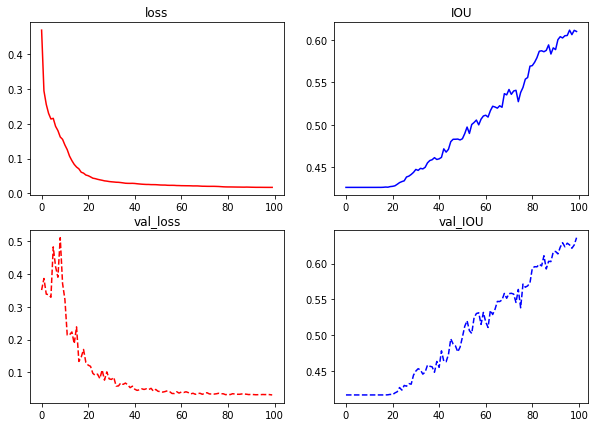

In [ ]:
showfigs(unet_model_history)

In [ ]:
preds_combine = unet_model.predict(x_test)
realMIOU(y_test, preds_combine)

tf.Tensor(0.734079, shape=(), dtype=float32)


In [ ]:
preds = unet_model.predict(x_test0)
realMIOU(y_test0, preds)

tf.Tensor(0.7847179, shape=(), dtype=float32)


In [ ]:
preds = unet_model.predict(x_test1)
realMIOU(y_test1, preds)

tf.Tensor(0.70051265, shape=(), dtype=float32)


In [ ]:
preds = unet_model.predict(x_test2)
realMIOU(y_test2, preds)

tf.Tensor(0.7089499, shape=(), dtype=float32)


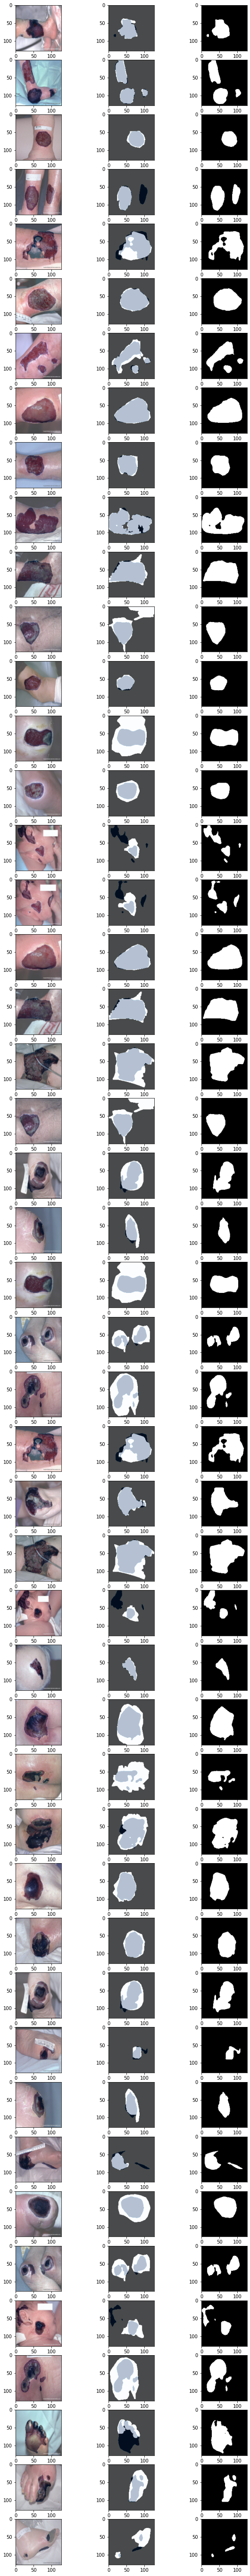

In [ ]:
showsegs(x_test, y_test, preds_combine)

In [ ]:
#@title 이하는 사용하지 않는 코드입니다

(array([82.01423991,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

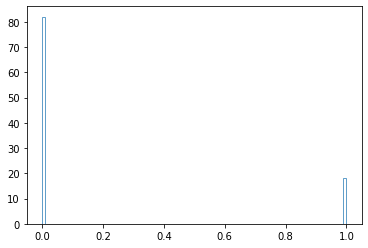

In [ ]:
#prediction 값 분포를 보고 threshold 정하기
plt.hist(np.ravel(preds_combine, order='C'), bins=100, density=True, alpha=0.7, histtype='step')

In [ ]:
np.save("/content/drive/My Drive/MLDL_models/TESTdataset/x_test.npy", x_test) ; np.save("/content/drive/My Drive/MLDL_models/TESTdataset/y_test.npy", y_test)

In [ ]:
model.save('/content/drive/My Drive/MLDL_models/savedmodels/U-net_SEG_ori_granulation/') 

INFO:tensorflow:Assets written to: /content/drive/My Drive/MLDL_models/savedmodels/U-net_SEG_ori_granulation/assets


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/My Drive/MLDL_models/savedmodels/U-net_SEG_patience10_factor0.5/')